# IDENTIFIABILITY

This notebook explores issues with identifying parameters of a model.

**Identifiability**: Given a model $\dot{x} = f(x; \theta)$, where $x$ is a vector of floating concentrations and $\theta$ are parameters.
If we know $x$, can we find unique values for $\theta$?

# Preliminaries

In [1]:
!apt-get install libncurses5
!pip install -q tellurium==2.2.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
import pandas as pd
import numpy as np
import tellurium as te
import matplotlib.pyplot as plt

# Example

In [3]:
MODEL1 = """
S1 -> S2; k1*k2*S1
S2 -> S1; k3*S2
S3 ->; k4*S3

S1 = 10
S3 = 15
k1 = 1
k2 = 2
k3 = 3
k4 = 4
"""

In this model, what are:
* $x$
* $\theta$
* $f$

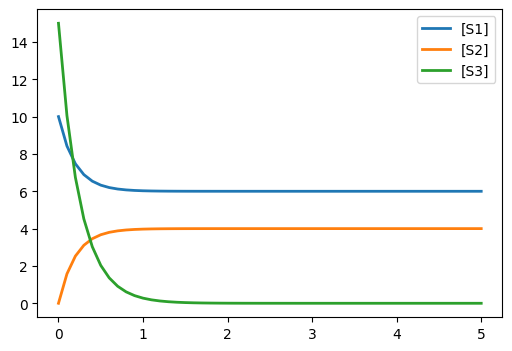

In [4]:
rr = te.loada(MODEL1)
data = rr.simulate()
rr.plot()

In [5]:
DATA1_DF = pd.DataFrame(data[30:,1:3], columns=["[S1]", "[S2]"], index=data[30:,0])
DATA1_DF.index.name = "time"
DATA1_DF

,[S1],[S2]
time,,
3.0,6.000001,3.999999
3.1,6.000001,3.999999
3.2,6.000000,4.000000
3.3,6.000000,4.000000
3.4,6.000000,4.000000
3.5,6.000000,4.000000
3.6,6.000000,4.000000
3.7,6.000000,4.000000
3.8,6.000000,4.000000


In [6]:
def simulate(model=MODEL1, species=["[S1]", "[S2]", "[S3]"], parameter_dct=None, start_time=0, is_plot=True):
    """
    Simulate the model and plot the result. Assumes 10 points per second.
    Note that species names must be enclosed in square brackets.

    Parameters
    ----------
    model: str (antimony model)
    species: list-str (species to include)
    start_index: int (index of data to report)
    is_plot: bool (plot the result)
    parameter_dct: dict (parameters to change)

    Returns
    -------
    DataFrame
        Columns: species values
        Index: times
    """
    POINT_PER_SEC = 10
    END_TIME = 5
    TIME = "time"
    NUM_POINT = 50
    num_point = int((END_TIME - start_time)*10) + 1
    #
    rr = te.loada(model)
    # Change the parameters
    if parameter_dct is None:
        parameter_dct = {}
    for key, value in parameter_dct.items():
        rr[key] = value
    # Find the columns
    colnames = list(species)
    all_colnames = list(colnames)
    all_colnames.insert(0, TIME)
    num_species = len(species)
    # Simulate
    data = rr.simulate(0, END_TIME, NUM_POINT, all_colnames)
    # Construct the dataframe
    column_idxs = np.array([i for i in range(len(colnames)) if species[i] in species], dtype=int)
    column_idxs += 1
    df = pd.DataFrame(data[:, column_idxs], columns=species)
    df.index = data[:, 0]
    df.index.name = TIME
    df = df[df.index >= start_time]
    if is_plot:
        _, ax = plt.subplots(1, figsize=(3,3))
        df.plot(ax=ax)
        title = ""
        for key, value in parameter_dct.items():
            title = title + "%s=%2.2f " % (key, value)
        ax.set_title(title)
    return df

# Tests
df = simulate(MODEL1, is_plot=False)
assert(isinstance(df, pd.DataFrame))
assert(len(df.columns) == 3)
assert(len(df) > 0)
#
df = simulate(MODEL1, start_time=3, species=["[S1]", "[S2]"], is_plot=False)
diff = np.sum([ (x - y)**2 for x, y in zip(df.values, DATA1_DF.values)])
assert(np.isclose(diff, 0))
#
df1 = simulate(MODEL1, start_time=3, species=["[S1]", "[S2]"], is_plot=False, parameter_dct={"k1": 100})
diff = np.sum((df["[S1]"] - df1["[S1]"])**2)
assert(diff > 0)
print("OK!")

OK!


Given ``DATA1_DF``, can we find ``k1``, ``k2``, ``k3``, ``k4``?

# Can we find ``k4`` from ``DATA1_DF``?

This question is equivalent to "Does k4 affect DATA1_DF?"

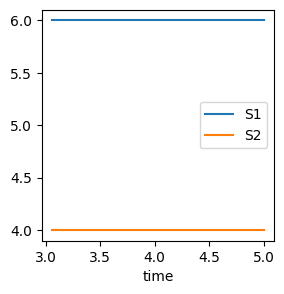

In [7]:
MODEL1 = """
S1 -> S2; k1*k2*S1
S2 -> S1; k3*S2
S3 ->; k4*S3

S1 = 10
S3 = 15
k1 = 1
k2 = 2
k3 = 3
k4 = 4
"""
_ = simulate(start_time=3, species=["S1", "S2"])

Do we see a different output if we change ``k4``? If not, it's not identifiable.

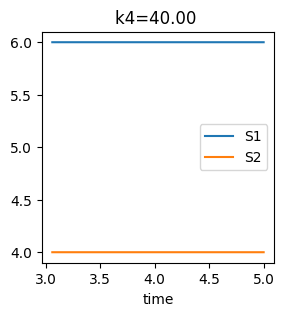

In [8]:
_ = simulate(start_time=3, species=["S1", "S2"], parameter_dct={"k4": 40})

**Rule**: To be identifiable, a parameter must affect the output.

# Can we find ``k1``, ``k2``, ``k3`` from DATA1_DF?

These parameters affect the output. Can they be uniquely identified?

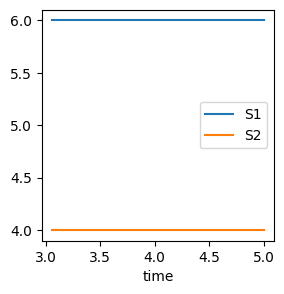

In [9]:
_ = simulate(start_time=3, species=["S1", "S2"])

Is there an effect if we change ``k3`` by a factor of 10?

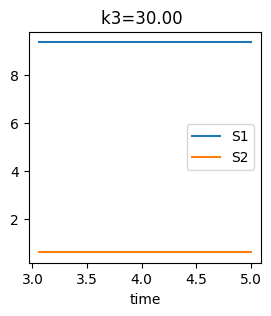

In [10]:
DATA1_DF = simulate(start_time=3, species=["S1", "S2"], parameter_dct={"k3": 30})

Yes, there's an effect. But the parameter is not uniquely identified. Compare ``(k2, k3) = (2, 3)`` with ``(20, 30)``.

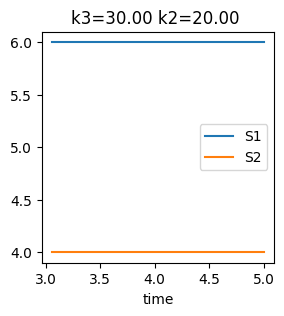

In [11]:
_ = simulate(start_time=3, species=["S1", "S2"], parameter_dct={"k3": 30, "k2": 20})

Can we do better with more dynamics in the data?

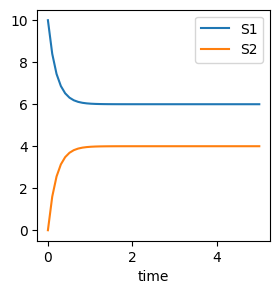

In [12]:
_ = simulate(start_time=0, species=["S1", "S2"])

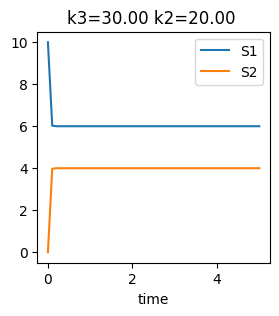

In [13]:
_ = simulate(start_time=0, species=["S1", "S2"], parameter_dct={"k3": 30, "k2": 20})

# Handling parameters that appear in combination

Can we find unique values for ``k1``, ``k2``?

In [14]:
MODEL1 = """
S1 -> S2; k1*k2*S1
S2 -> S1; k3*S2
S3 ->; k4*S3

S1 = 10
S3 = 15
k1 = 1
k2 = 2
k3 = 3
k4 = 4
"""

# Insights into Identifiability

1. Can only identify parameters that affect the output data.
1. We can sometimes see an effect of a parameter on output data by using more data.
1. Can only identify parameters that occur in isolation (or can be inferred from combinations).